In [ ]:
!pip install --upgrade monai



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.7 MB/s eta 0:00:00


In [ ]:
# mount google drive content
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# get and display the file path of the current file in GDrive
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Auto-Segmentation'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive',
                                 GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install nibabel

In [ ]:
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from monai.apps.auto3dseg import AutoRunner
from monai.config import print_config
from monai.data import create_test_image_3d

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 11.0.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.66.6
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.46.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/l

In [ ]:
def load_data(data_path, label_path, diff=False):
  x = np.load(data_path)['X']
  x = x / np.max(x)

  y = np.load(label_path)['Y']
  y = y / np.max(y)

  for i in range(y.shape[0]):
    for j in range(y.shape[4]):
      for k in range(y.shape[3]):
        y[i, :, :, k, j] = y[i, :, :, k, j].T

  if not diff:
    X = np.zeros((x.shape[0] * x.shape[-1], 512, 512, 64))
    Y = np.zeros((y.shape[0] * y.shape[-1], 512, 512, 64))

    count = 0
    for i in range(x.shape[0]):
      for j in range(x.shape[-1]):
        X[count, :, :, :] = x[i, :, :, :, j]
        Y[count, :, :, :] = y[i, :, :, :, j]

        count += 1

    return X, Y

  else:
    return x, y

def separate_z(x, y):
  X = np.zeros((x.shape[0] * x.shape[-1], 512, 512))
  Y = np.zeros((y.shape[0] * y.shape[-1], 512, 512))

  count = 0

  for i in range(x.shape[0]):
    for j in range(x.shape[-1]):
      X[count, :, :] = x[i, :, :, j]
      Y[count, :, :] = y[i, :, :, j]
      count += 1

  return X, Y

In [ ]:
data_path = os.path.join(GOOGLE_DRIVE_PATH, 'data/X1.npz')
label_path = os.path.join(GOOGLE_DRIVE_PATH, 'data/Y1.npz')

In [ ]:
# Set up data here
x, y = load_data(data_path, label_path)
X, Y = separate_z(x, y)
# seperating the data to reduce dimensionality for monai !


In [ ]:
# here we will choose our test splits for training

test_split = 0.05
loc = int(X.shape[0] * test_split)
loc = 5
x_train = x[loc:, :, :,:]
x_test = x[:loc, :, :,:]
y_train = y[loc:, :, :,:]
y_test = y[:loc, :, :,:]

In [ ]:
print(y_train.shape)

(15, 512, 512, 64)


In [ ]:
import nibabel as nib
def save_arrays_to_nii(data, work_dir, train=True,test=False, image=True):
  """
  Saves each array in a list of arrays to a separate .nii.gz file.

  Args:
    data: A list of NumPy arrays.
    work_dir: The directory where the .nii.gz files will be saved.
  """
  affine = np.eye(4)
  if train and image:
    for index, array in enumerate(data):
      filename = f"{work_dir}/tr_image_{str(index + 1).zfill(3)}.nii.gz"
      nib.save(nib.Nifti1Image(array, affine), filename)
  elif train and not image:
    for index, array in enumerate(data):
      filename = f"{work_dir}/tr_label_{str(index + 1).zfill(3)}.nii.gz"
      nib.save(nib.Nifti1Image(array, affine), filename)
  elif test and image:
    for index, array in enumerate(data):
      filename = f"{work_dir}/te_image_{str(index + 1).zfill(3)}.nii.gz"
      nib.save(nib.Nifti1Image(array, affine), filename)
  elif test and not image:
    for index, array in enumerate(data):
      filename = f"{work_dir}/te_label_{str(index + 1).zfill(3)}.nii.gz"
      nib.save(nib.Nifti1Image(array, affine), filename)



work_dir = "./Auto-Segmentation"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

save_arrays_to_nii(x_train, work_dir)
save_arrays_to_nii(x_test, work_dir,train=False,test=True)
save_arrays_to_nii(y_train, work_dir,image=False)
save_arrays_to_nii(y_test, work_dir,train=False,test=True,image=False)


train_data = {"image": x_train, "label": y_train}
test_data = {"image": x_test, "label": y_test}
sim_datalist = {"testing": test_data, "training": train_data}


In [ ]:
def get_nii_files(directory):
  """
  Returns a list of all files with the .nii.gz extension in a directory.

  Args:
    directory: The directory to search for files.

  Returns:
    A list of filenames with the .nii.gz extension.
  """

  nii_files = []
  for filename in os.listdir(directory):
    if filename.endswith(".nii.gz"):
      nii_files.append(filename)

  return nii_files

# Example usage:
work_dir = "./Auto-Segmentation"
nii_files = get_nii_files(work_dir)

# Print the list of .nii.gz files
print(nii_files)

['tr_image_009.nii.gz', 'tr_label_005.nii.gz', 'tr_image_003.nii.gz', 'te_label_002.nii.gz', 'tr_label_011.nii.gz', 'tr_image_001.nii.gz', 'tr_label_007.nii.gz', 'tr_image_008.nii.gz', 'tr_image_011.nii.gz', 'tr_image_002.nii.gz', 'te_label_005.nii.gz', 'tr_label_015.nii.gz', 'tr_label_012.nii.gz', 'tr_label_013.nii.gz', 'tr_label_008.nii.gz', 'tr_image_013.nii.gz', 'te_image_002.nii.gz', 'tr_label_009.nii.gz', 'te_image_003.nii.gz', 'tr_image_015.nii.gz', 'tr_label_003.nii.gz', 'te_image_004.nii.gz', 'tr_image_006.nii.gz', 'te_label_001.nii.gz', 'tr_image_010.nii.gz', 'te_label_003.nii.gz', 'tr_image_012.nii.gz', 'tr_image_014.nii.gz', 'tr_label_010.nii.gz', 'tr_label_004.nii.gz', 'tr_label_014.nii.gz', 'te_label_004.nii.gz', 'tr_label_001.nii.gz', 'tr_image_007.nii.gz', 'tr_image_004.nii.gz', 'te_image_005.nii.gz', 'te_image_001.nii.gz', 'tr_image_005.nii.gz', 'tr_label_006.nii.gz', 'tr_label_002.nii.gz']


In [ ]:
print(os.listdir(work_dir))

sim_datalist = {
  "testing": [
      {"image": 'te_image_001.nii.gz', "label": 'te_label_001.nii.gz'},
      {"image": 'te_image_002.nii.gz', "label": 'te_label_002.nii.gz'},
      {"image": 'te_image_003.nii.gz', "label": 'te_label_003.nii.gz'},
      {"image": 'te_image_004.nii.gz', "label": 'te_label_004.nii.gz'},
      {"image": 'te_image_005.nii.gz', "label": 'te_label_005.nii.gz'},
  ],
  "training": [
      {"fold": 0, "image": 'tr_image_001.nii.gz', "label": "tr_label_001.nii.gz"},
      {"fold": 0, "image": 'tr_image_002.nii.gz', "label": "tr_label_002.nii.gz"},
      {"fold": 0, "image": 'tr_image_003.nii.gz', "label": "tr_label_003.nii.gz"},
      {"fold": 0, "image": 'tr_image_004.nii.gz', "label": "tr_label_004.nii.gz"},
      {"fold": 0, "image": 'tr_image_005.nii.gz', "label": "tr_label_005.nii.gz"},
      {"fold": 1, "image": 'tr_image_006.nii.gz', "label": "tr_label_006.nii.gz"},
      {"fold": 1, "image": 'tr_image_007.nii.gz', "label": "tr_label_007.nii.gz"},
      {"fold": 1, "image": 'tr_image_008.nii.gz', "label": "tr_label_008.nii.gz"},
      {"fold": 1, "image": 'tr_image_009.nii.gz', "label": "tr_label_009.nii.gz"},
      {"fold": 1, "image": 'tr_image_010.nii.gz', "label": "tr_label_010.nii.gz"},
      {"fold": 2, "image": 'tr_image_011.nii.gz', "label": "tr_label_011.nii.gz"},
      {"fold": 2, "image": 'tr_image_012.nii.gz', "label": "tr_label_012.nii.gz"},
      {"fold": 2, "image": 'tr_image_013.nii.gz', "label": "tr_label_013.nii.gz"},
      {"fold": 2, "image": 'tr_image_014.nii.gz', "label": "tr_label_014.nii.gz"},
      {"fold": 2, "image": 'tr_image_015.nii.gz', "label": "tr_label_015.nii.gz"},
  ],
  }

['tr_image_009.nii.gz', 'tr_label_005.nii.gz', 'tr_image_003.nii.gz', 'te_label_002.nii.gz', 'tr_label_011.nii.gz', 'tr_image_001.nii.gz', 'tr_label_007.nii.gz', 'tr_image_008.nii.gz', 'tr_image_011.nii.gz', 'tr_image_002.nii.gz', 'te_label_005.nii.gz', 'tr_label_015.nii.gz', 'tr_label_012.nii.gz', 'tr_label_013.nii.gz', 'tr_label_008.nii.gz', 'tr_image_013.nii.gz', 'te_image_002.nii.gz', 'tr_label_009.nii.gz', 'te_image_003.nii.gz', 'tr_image_015.nii.gz', 'tr_label_003.nii.gz', 'te_image_004.nii.gz', 'tr_image_006.nii.gz', 'te_label_001.nii.gz', 'tr_image_010.nii.gz', 'te_label_003.nii.gz', 'tr_image_012.nii.gz', 'tr_image_014.nii.gz', 'tr_label_010.nii.gz', 'tr_label_004.nii.gz', 'tr_label_014.nii.gz', 'te_label_004.nii.gz', 'tr_label_001.nii.gz', 'tr_image_007.nii.gz', 'tr_image_004.nii.gz', 'te_image_005.nii.gz', 'te_image_001.nii.gz', 'tr_image_005.nii.gz', 'tr_label_006.nii.gz', 'tr_label_002.nii.gz']


In [ ]:
!pip install ujson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.6 MB/s eta 0:00:00


In [ ]:
import ujson
sim_dim = x.shape
work_dir = "./Auto-Segmentation"

dataroot_dir = work_dir
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)
datalist_file = os.path.join(work_dir, "sim_datalist.json")
with open(datalist_file, "w") as f:
    ujson.dump(sim_datalist, f)


In [ ]:
# print(os.listdir(f'{work_dir}/dints_0/configs'))
# import yaml
# with open(f'{work_dir}/dints_0/configs/hyper_parameters.yaml', "r") as f:
#     # Load the YAML file into a Python dictionary
#     data = yaml.load(f, Loader=yaml.FullLoader)
# data["bundle_root"] = datalist_file

# with open("hyper_parameters.yaml", "w") as f:
#     yaml.dump(data, f)
# # Print the dictionary
# print(data)

In [ ]:
# print(os.listdir(f'{work_dir}'))
# work_dir  = "Auto-Segmentation/dints_0"

# !torchrun --nnodes=1 --nproc_per_node=8 -m scripts.train run --config_file "['configs/hyper_parameters.json','configs/network.yaml','configs/transforms_train.json','configs/transforms_validate.json']"



In [ ]:

runner_jk = AutoRunner(
    work_dir=work_dir,
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": work_dir
    },
    algos=['dints', 'segresnet'],
    output_dir="./output_dir"
)


2024-12-10 15:19:35,845 - INFO - AutoRunner using work directory /content/Auto-Segmentation
2024-12-10 15:19:35,850 - INFO - Found num_fold 3 based on the input datalist /content/Auto-Segmentation/sim_datalist.json.
2024-12-10 15:19:35,852 - INFO - Setting num_fold 3 based on the input datalist /content/Auto-Segmentation/sim_datalist.json.
2024-12-10 15:19:35,882 - INFO - Using user defined command running prefix , will override other settings


In [ ]:
max_epochs = 6

train_param = {
    "num_epochs_per_validation": 1,
    "num_images_per_batch": 2,
    "num_epochs": max_epochs,
    "num_warmup_epochs": 1,
}
runner_jk.set_training_params(train_param)



In [ ]:
!pip install fire

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=d79068557a9f62c2a532c6dfbf1a50d40d50aa26bc34203e067f592f6b2ae0e0
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
runner_jk.run()


2024-12-10 15:20:16,582 - INFO - Running data analysis...
2024-12-10 15:20:17,177 - INFO - Found 1 GPUs for data analyzing!


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
print(os.listdir('./output_dir'))
work_dir = "./output_dir"

['te_image_001_ensemble.nii.gz', 'te_image_004_ensemble.nii.gz', 'te_image_002_ensemble.nii.gz', 'te_image_003_ensemble.nii.gz', 'te_image_005_ensemble.nii.gz']


In [ ]:
image_name = "te_image_005"
prediction_nib = nib.load(os.path.join(work_dir, image_name + "_ensemble" + ".nii.gz"))
pred = np.array(prediction_nib.dataobj)


In [ ]:
print(pred.shape)
print(y_test.shape)

(512, 512, 64)
(5, 512, 512, 64)


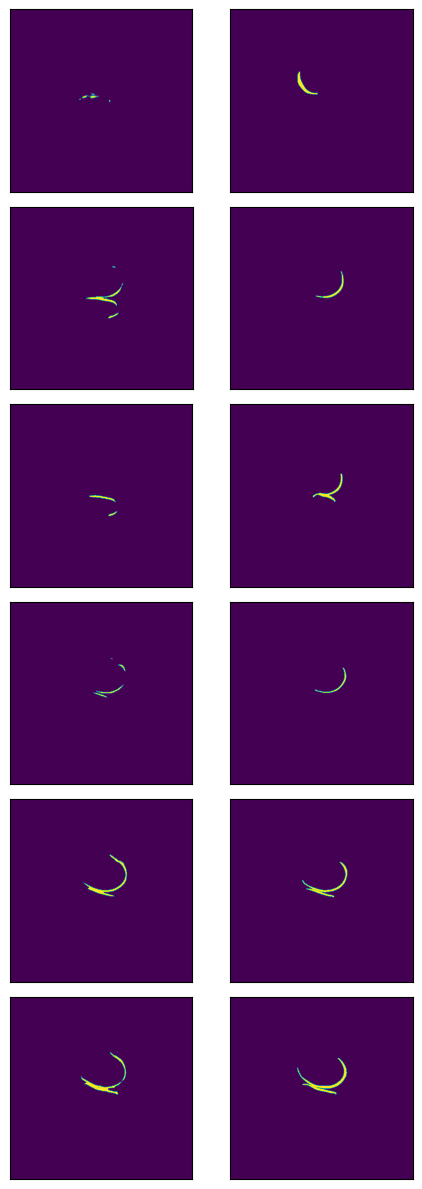

In [ ]:
plt.figure(figsize=(5, 12))

img = pred
lab = y_test[4,:,:,:]

for i in range(6):
  sub = np.random.randint(0, 64)

  plt.subplot(6, 2, 2*i+1)
  plt.imshow(img[:, :, sub])
  plt.xticks([])
  plt.yticks([])
  plt.subplot(6, 2, 2*i+2)
  plt.imshow(lab[:, :, sub])
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.show()

In [ ]:
# prompt: Make this code: image_name = "te_image_005"
# prediction_nib = nib.load(os.path.join(work_dir, image_name + "_ensemble" + ".nii.gz"))
# pred = np.array(prediction_nib.dataobj)
# iteratable to iterate through a list of image_names

import numpy as np
pred = []
image_names = ["te_image_001", "te_image_002", "te_image_003", "te_image_004","te_image_005"]
for image_name in image_names:
  prediction_nib = nib.load(os.path.join(work_dir, image_name + "_ensemble" + ".nii.gz"))
  pred.append(np.array(prediction_nib.dataobj))
  # Do something with pred


In [ ]:
pred = np.array(pred)
print(pred.shape)
# np.savez('pred.npz', data=pred)
# np.savez('y_test.npz', data=y_test)
# np.savez('y_train.npz', data=y_train)
# np.savez('x_test.npz', data=x_test)
# np.savez('x_train.npz', data=x_train)
save_path = '/content/drive/My Drive/Auto-Segmentation/' + 'output_dir' + '/pred.npz'
np.savez(save_path, data=pred)
np.savez('/content/drive/My Drive/Auto-Segmentation/' + work_dir + '/y_test.npz', data=y_test)
np.savez('/content/drive/My Drive/Auto-Segmentation/' + work_dir + '/y_train.npz', data=y_train)
np.savez('/content/drive/My Drive/Auto-Segmentation/' + work_dir + '/x_test.npz', data=x_test)
np.savez('/content/drive/My Drive/Auto-Segmentation/' + work_dir + '/x_train.npz', data=x_train)
np.savez('/content/drive/My Drive/Auto-Segmentation/' + work_dir + '/sim_datalist.npz', data=sim_datalist)
os.listdir(work_dir)

(5, 512, 512, 64)


['te_image_001_ensemble.nii.gz',
 'te_image_004_ensemble.nii.gz',
 'te_image_002_ensemble.nii.gz',
 'te_image_003_ensemble.nii.gz',
 'te_image_005_ensemble.nii.gz']

In [ ]:
print(work_dir)

./output_dir


In [ ]:
# prompt: Calculate the accuracy of pred to y_test with sklearn
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(pred.flatten(), y_test.flatten())
print(f"Accuracy: {accuracy:.4f}")
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
# Calculate F1 score
f1 = f1_score(y_test.flatten(), pred.flatten())

# Calculate DICE score
dice = dice_coefficient(y_test, pred)

# Calculate precision
precision = precision_score(y_test.flatten(), pred.flatten())

# Calculate recall
recall = recall_score(y_test.flatten(), pred.flatten())

# Generate classification report
report = classification_report(y_test.flatten(), pred.flatten())

# Print all the scores
print("F1 Score:", f1)
print("DICE Score:", dice)
print("Precision:", precision)
print("Recall:", recall)
print("Classification Report:\n", report)

Accuracy: 0.9969
F1 Score: 0.4699138100609793
DICE Score: 0.46991381006097926
Precision: 0.4232495073490861
Recall: 0.5281428642329575
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00  83664443
         1.0       0.42      0.53      0.47    221637

    accuracy                           1.00  83886080
   macro avg       0.71      0.76      0.73  83886080
weighted avg       1.00      1.00      1.00  83886080



In [ ]:
dice = dice_coefficient(y_test, pred)
print(dice)

0.46991381006097926


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)


(15, 512, 512, 64)
(15, 512, 512, 64)
(5, 512, 512, 64)


In [ ]:
import cv2
def shrink_xy(img, xs=128, ys=128):
    """
    Reduce the xy resolution of a 3D image.

    Parameters:
      img (numpy array) : input image
      xs (int) : new x resolution
      ys (int) : new y resolution

    Output:
      res (numpy array) : output image
    """
    res = np.zeros((xs, ys, 64))
    for i in range(64):
      res[:, :, i] = cv2.resize(img[:, :, i], (xs, ys))

    return res

In [ ]:
work_dir = "./output_dir"


pred = np.load('/content/drive/My Drive/Auto-Segmentation/' + work_dir + '/pred.npz')
y_test = np.load('/content/drive/My Drive/Auto-Segmentation/' + work_dir + '/y_test.npz')
y_train = np.load('/content/drive/My Drive/Auto-Segmentation/' + work_dir + '/y_train.npz')
x_test = np.load('/content/drive/My Drive/Auto-Segmentation/' + work_dir + '/x_test.npz')
x_train = np.load('/content/drive/My Drive/Auto-Segmentation/' + work_dir + '/x_train.npz')



In [ ]:
print(pred['data'].shape)

(5, 512, 512, 64)


In [ ]:
def predictions_to_stack(y_pred, stack_size=64):
  """
  Converts a group of 2D arrays into a 3D array

  Parameters:
    y_pred (numpy array) : array of shape (n, xd, yd)
    stack_size (int) : number of frames to stack

  Output:
    stacked_y (numpy array) : array of shape
        (n // stack_size, xd, yd, stack_size)


  """

  assert y_pred.shape[0] % stack_size == 0

  n_stacks = y_pred.shape[0] // stack_size

  stacked_y = np.zeros((n_stacks, y_pred.shape[1], y_pred.shape[2], stack_size))

  for i in range(n_stacks):
    stacked_y[i, :, :, :] = y_pred[i * stack_size:(i + 1) * stack_size, :, :]

  return stacked_y

In [ ]:
print(y_test['data'].shape)

(5, 512, 512, 64)


In [ ]:
from numpy import linspace
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# y_predt_stack = np.transpose(pred['data'][0], (0, 1, 2)).astype(np.uint8)
# y_test_stack = np.transpose(y_test['data'][0], (0, 1, 2)).astype(np.uint8)

y_predt_stack = shrink_xy(predictions_to_stack(pred['data'][0]))
y_test_stack = shrink_xy(predictions_to_stack(y_test['data'][0]))

# Creating 3D figure
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax = plt.figure().add_subplot(projection='3d')

ax.voxels(y_test_stack, alpha=0.5, label='Test')
ax.voxels(y_predt_stack, alpha=0.5, label='Predicted')
plt.show()

# 360 Degree view
# for angle in range(0, 360):
#     ax.view_init(angle, 30)
#     plt.draw()
#     plt.pause(.001)

plt.show()

ValueError: could not broadcast input array from shape (64,512,64) into shape (512,64,64)